In [1]:
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import pandas as pd
import os
import numpy as np
import scipy.stats as stats
import tensorflow as tf
from datetime import datetime, timedelta
import wandb
from wandb.keras import WandbCallback
import graphviz

In [2]:
wandb.init(project="NFT-prediction")


wandb: Currently logged in as: emchro. Use `wandb login --relogin` to force relogin


In [9]:
wandb.config = {
  "learning_rate": 0.001,
  "epochs": 25,
  "batch_size": 32
}

In [10]:
f = open("../data/prediction.csv", 'r')
pred = pd.read_csv(f)
del pred['Unnamed: 0']
pred["Date"] = pd.to_datetime(pred['Date'], format='%Y-%m-%d')
pred = pred.astype({'Number_of_sales':'float32','Active_markets_wallets':'float32','Primary_sales':'float32','ETH_high_price':'float32'})
pred.head()


,Date,Number_of_sales,Active_markets_wallets,Primary_sales,ETH_high_price
0,2017-11-09,2.0,0.0,0.0,329.451996
1,2017-11-10,0.0,0.0,0.0,324.717987
2,2017-11-11,0.0,0.0,0.0,319.453003
3,2017-11-12,1.0,0.0,0.0,319.153015
4,2017-11-13,2.0,2.0,0.0,328.415009


In [11]:
pred = pred.replace('?', np.nan)
pred = pred.replace('null', np.nan)

def fill_missing(values):
    for row in range(pred.shape[0]):
        for col in range(pred.shape[1]):
            if (values[row][col] == np.nan):
                values[row,col] = values[row-1, col]
pred.isnull().sum()

Date                      0
Number_of_sales           0
Active_markets_wallets    8
Primary_sales             0
ETH_high_price            0
dtype: int64

In [12]:

fill_missing(pred.values)
pred.isnull().sum()
for i in range(pred.shape[0]):
    if (type(pred.iloc[i]["Active_markets_wallets"]) != np.float32):
        print(i)


In [13]:
#75% 25% split
# 1466*0.75 = 1099
train_df,test_df = pred[1:1099], pred[1099:] 

from sklearn.preprocessing import MinMaxScaler
#min max
train = train_df
scalers={}
for i in train_df.columns:
    if (i == "Date"):
        #skip
        print("nothing")
    else:
        scaler = MinMaxScaler(feature_range=(-1,1))
        s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
        s_s=np.reshape(s_s,len(s_s))
        scalers['scaler_'+ i] = scaler
        train[i]=s_s
test = test_df
for i in train_df.columns:
    if (i == "Date"):
        #skip
        print("nothing")
    else:
        scaler = scalers['scaler_'+i]
        s_s = scaler.transform(test[i].values.reshape(-1,1))
        s_s=np.reshape(s_s,len(s_s))
        scalers['scaler_'+i] = scaler
        test[i]=s_s

nothing
nothing


C:\Users\aitbudapest\AppData\Local\Temp\ipykernel_14396\2930816559.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
C:\Users\aitbudapest\AppData\Local\Temp\ipykernel_14396\2930816559.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
C:\Users\aitbudapest\AppData\Local\Temp\ipykernel_14396\2930816559.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [14]:
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

#use 10 days to predict 5 days into the future
n_past = 10
n_future = 5 
n_features = 5

In [15]:
#split into samples 
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [16]:
#Now we will create two models in the below-mentioned architecture.
#E1D1 ==> Sequence to Sequence Model with one encoder layer and one decoder layer.

# E1D1
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

#
model_e1d1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 5)]      0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 100),        42400       ['input_1[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 repeat_vector (RepeatVector)   (None, 5, 100)       0           ['lstm[0][0]']                   
                                                                                              

In [17]:
#E2D2 ==> Sequence to Sequence Model with two encoder layers and two decoder layers.

# E2D2
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10, 5)]      0           []                               
                                                                                                  
 lstm_2 (LSTM)                  [(None, 10, 100),    42400       ['input_2[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_3 (LSTM)                  [(None, 100),        80400       ['lstm_2[0][0]']                 
                                 (None, 100),                                               

In [28]:
#fit data attempt 1
history = model_e1d1.fit(X_train, # input data
                    y_train, # target data
                    batch_size=1, # Number of samples per gradient update. If unspecified, batch_size will default to 32.
                    epochs=1000, # default=1, Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
                    verbose=1, # default='auto', ('auto', 0, 1, or 2). Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. 'auto' defaults to 1 for most cases, but 2 when used with ParameterServerStrategy.
                    callbacks=[WandbCallback()], # default=None, list of callbacks to apply during training. See tf.keras.callbacks
                    #callbacks=[WandbCallback()]
                    validation_split=0.2, # default=0.0, Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch. 
                    validation_data=(X_test, y_test), # default=None, Data on which to evaluate the loss and any model metrics at the end of each epoch. 
                    shuffle=True, # default=True, Boolean (whether to shuffle the training data before each epoch) or str (for 'batch').
                    class_weight=None, # default=None, Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only). This can be useful to tell the model to "pay more attention" to samples from an under-represented class.
                    sample_weight=None, # default=None, Optional Numpy array of weights for the training samples, used for weighting the loss function (during training only).
                    initial_epoch=0, # Integer, default=0, Epoch at which to start training (useful for resuming a previous training run).
                    steps_per_epoch=None, # Integer or None, default=None, Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch. When training with input tensors such as TensorFlow data tensors, the default None is equal to the number of samples in your dataset divided by the batch size, or 1 if that cannot be determined. 
                    validation_steps=None, # Only relevant if validation_data is provided and is a tf.data dataset. Total number of steps (batches of samples) to draw before stopping when performing validation at the end of every epoch.
                    validation_batch_size=None, # Integer or None, default=None, Number of samples per validation batch. If unspecified, will default to batch_size.
                    validation_freq=100, # default=1, Only relevant if validation data is provided. If an integer, specifies how many training epochs to run before a new validation run is performed, e.g. validation_freq=2 runs validation every 2 epochs.
                    max_queue_size=10, # default=10, Used for generator or keras.utils.Sequence input only. Maximum size for the generator queue. If unspecified, max_queue_size will default to 10.
                    workers=1, # default=1, Used for generator or keras.utils.Sequence input only. Maximum number of processes to spin up when using process-based threading. If unspecified, workers will default to 1.
                    use_multiprocessing=True, # default=False, Used for generator or keras.utils.Sequence input only. If True, use process-based threading. If unspecified, use_multiprocessing will default to False. 
                   )

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type Timestamp).

In [30]:
##### Step 6 - Use model to make predictions
# Predict results on training data
pred_train = model_e1d1.predict(X_train)
# Predict esults on test data
pred_test = model_e1d1.predict(X_test)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type Timestamp).

In [26]:
#fit data other attempt
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())

history_e1d1=model_e1d1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])
model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type Timestamp).

# Graphing and visualization time
idk what these are telling us but don't they look fun?

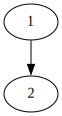

In [25]:
#run this to check that graphviz is working
from graphviz import Digraph

dot = Digraph()
dot.node('1')
dot.node('2')
dot.edges(['12'])
dot

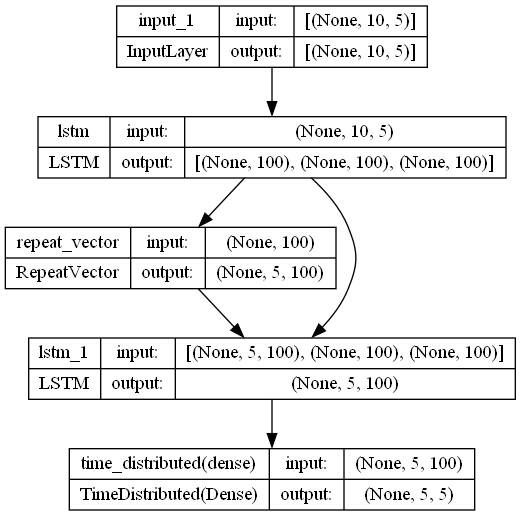

In [23]:
#graph model attempts
import pydot
from keras.utils.vis_utils import plot_model
import graphviz

plot_model(model_e1d1, to_file='../visuals/model_e1d1_plot.png', show_shapes=True, show_layer_names=True)

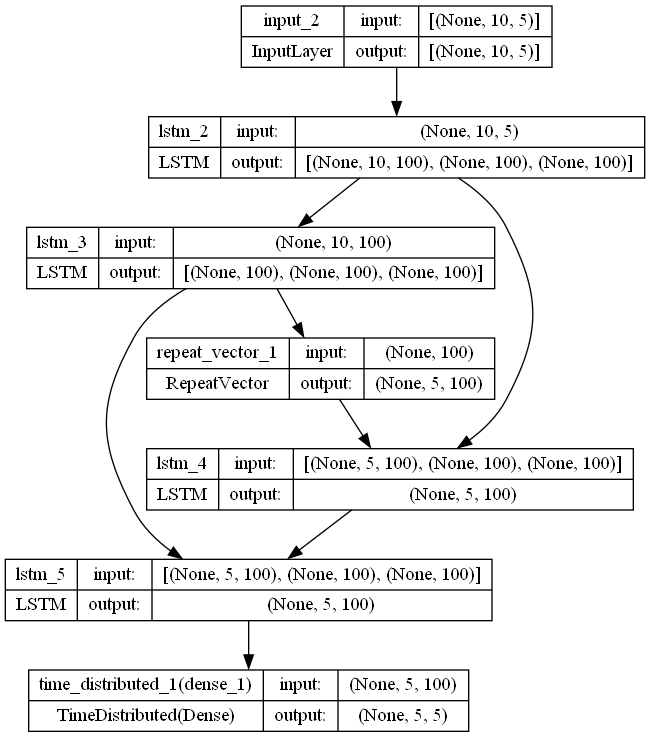

In [24]:
#plotting E2D2
plot_model(model_e2d2, to_file='../visuals/model_e2d2_plot.png', show_shapes=True, show_layer_names=True)